# Sim-Real Data Experiment

In [1]:
import sys, os

sys.path.append("/home/emmanuel/code/isp_data")
sys.path.append("/home/emmanuel/code/gp_model_zoo/code/numpyro")

from jax.config import config
from jax import device_put
import jax.numpy as jnp

# from jax import random
# import numpy as np

# import chex
config.update("jax_enable_x64", False)

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================
# INITIALIZE LOGGER
# ==========================
import wandb

wandb_logger = wandb.init(project="egp_1_1", entity="ipl_uv")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
wandb.config.exp = "simreal"
wandb.config.seed = 123

## Load Demo Data

In [4]:
from isp_data.simulation import uncertain

X, y = uncertain.load_prosail_training_df()

In [5]:
X.describe()

,Band 1: Blue,Band 2: Green,Band 3: Red,Band 4: NIR,Band 6: SWIR 1.6,Band 7: SWIR 2.1
count,3303.000000,3303.000000,3303.000000,3303.000000,3303.000000,3303.000000
mean,0.068743,0.105825,0.111666,0.362267,0.260562,0.173583
std,0.046820,0.061809,0.079168,0.123083,0.092832,0.094373
min,0.005332,0.006786,0.005533,0.033154,0.033389,0.009375
25%,0.035533,0.060806,0.053779,0.273694,0.194152,0.104310
50%,0.053992,0.089028,0.086402,0.363865,0.252580,0.152875
75%,0.087720,0.134440,0.148359,0.448729,0.317240,0.225726
max,0.279228,0.360767,0.437059,0.766682,0.569299,0.530368


In [6]:
y.describe()

,LAI,FVC,FAPAR,CWC (g/cm2),CCC (g/cm2)
count,3303.000000,3303.000000,3303.000000,3303.000000,3303.000000
mean,2.262788,0.592697,0.573906,0.040715,0.105892
std,1.853207,0.394076,0.356829,0.047395,0.100914
min,0.000015,0.000007,0.000010,0.000000,0.000000
25%,0.321631,0.157449,0.193685,0.004334,0.011619
50%,2.227418,0.691581,0.680800,0.027279,0.083860
75%,3.640792,0.929118,0.871570,0.058701,0.167256
max,7.764345,1.266707,1.137658,0.506256,0.539141


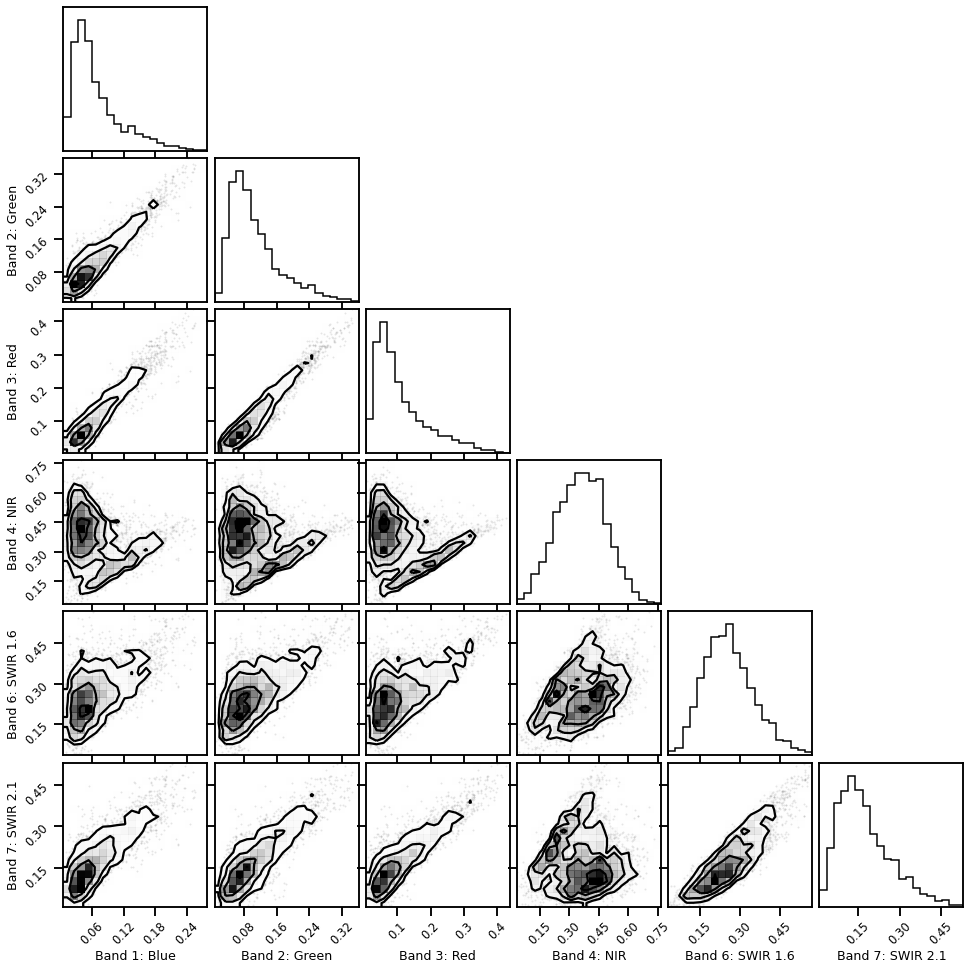

In [7]:
import corner

figure = corner.corner(X)
plt.gcf()
wandb.log({"sim_data_X": wandb.Image(plt)})

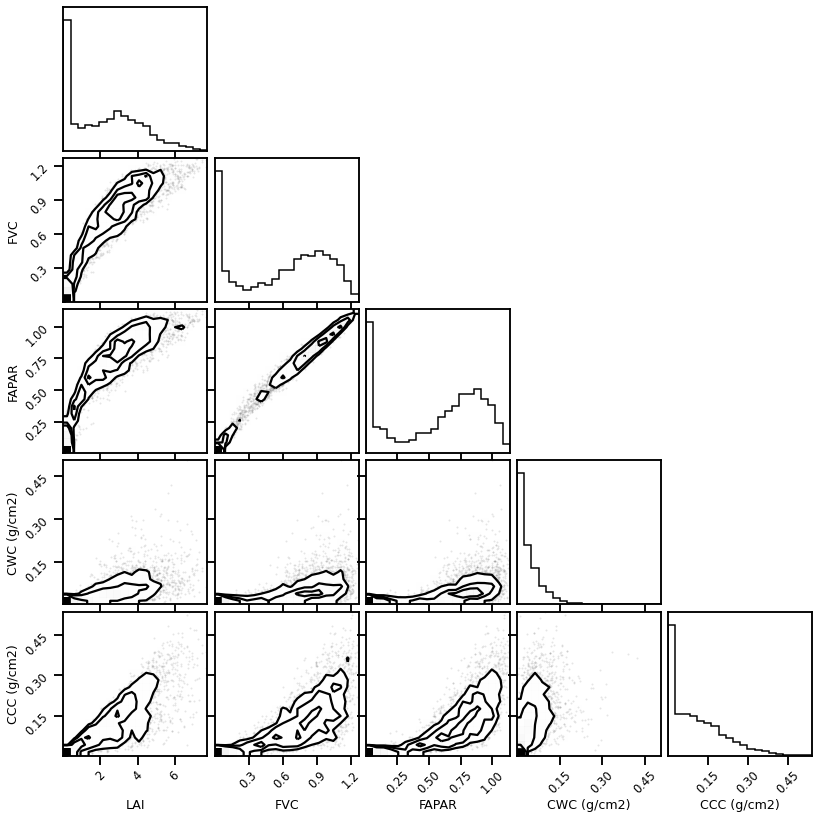

In [8]:
import corner

figure = corner.corner(y)
plt.gcf()
wandb.log({"sim_data_y": wandb.Image(plt)})

### Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split

random_state = 123
train_size = 500

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y.iloc[:, 0], train_size=train_size, random_state=random_state,
)

### Standardization

In [10]:
from sklearn.preprocessing import StandardScaler

x_transformer = StandardScaler()

Xtrain_scaled = x_transformer.fit_transform(Xtrain)
Xtest_scaled = x_transformer.transform(Xtest)

y_transformer = StandardScaler(with_std=False)

ytrain_scaled = y_transformer.fit_transform(ytrain.values.reshape(-1, 1))
ytest_scaled = y_transformer.transform(ytest.values.reshape(-1, 1))

## GP Model

In [11]:
import chex
import jax
import jax.numpy as jnp
from chex import Array
from src.utils import identity_matrix, add_to_diagonal
from src.kernels import RBF

n_features = Xtrain.shape[1]

rbf_kernel = RBF(length_scale=jnp.ones(n_features), variance=1.0)
K = rbf_kernel.gram(Xtrain.values)

# check shape
chex.assert_shape(K, (Xtrain.shape[0], Xtrain.shape[0]))

model = "exact"
wandb.config.model = model

#### Model

In [12]:
# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO
from src.utils import init_inducing_subsample, init_inducing_kmeans
from src.sparse import init_default_sgp_model
from src.exact import init_default_gp_model

jitter = 1e-5
inference = "map"

n_inducing = 100
n_length_scales = Xtrain.shape[1]
wandb.config.jitter = jitter

wandb.config.inference = inference
wandb.config.n_inducing = n_inducing
wandb.config.n_length_scales = n_length_scales

if model == "exact":

    numpyro_model = init_default_gp_model(
        n_features=n_length_scales, inference=inference, jitter=jitter
    )


elif model == "sparse":

    n_inducing = 100

    numpyro_model = init_default_sgp_model(
        Xtrain_scaled,
        n_features=n_length_scales,
        inference=inference,
        n_inducing=n_inducing,
        jitter=jitter,
    )


else:
    raise ValueError(f"Unrecognized model: {model}")


def empty_guide(X, y):
    pass

In [13]:
# NUMPYRO SETTINGS
with numpyro.handlers.seed(rng_seed=123):
    t = numpyro_model(Xtrain.values, ytrain.values)

assert t.shape == ytrain.shape

#### Inference

In [14]:
from numpyro.infer.autoguide import (
    AutoDelta,
    AutoMultivariateNormal,
    AutoDiagonalNormal,
)

# ===================
# Model
# ===================
# GP model

# delta guide - basically deterministic


if inference == "map":
    guide = AutoDelta(numpyro_model)
elif inference == "vi_mf":
    guide = AutoDiagonalNormal(numpyro_model)
elif inference == "vi_full":
    guide = AutoMultivariateNormal(numpyro_model)
elif inference == "mll":

    def empty_guide(X, y):
        pass

    guide = empty_guide
else:
    raise ValueError(f"Unrecognized inference scheme: {inference}")

#### Training

In [15]:
# reproducibility
rng_key = jax.random.PRNGKey(0)

# Setup
wandb.config.step_size = 0.01
wandb.config.train_seed = 42
wandb.config.iterations = 2_500


# Setup
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(numpyro_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(42), 2_500, Xtrain_scaled, ytrain_scaled.T)

100%|██████████| 2500/2500 [00:35<00:00, 71.24it/s, init loss: 1012.4955, avg. loss [2376-2500]: 621.3828]


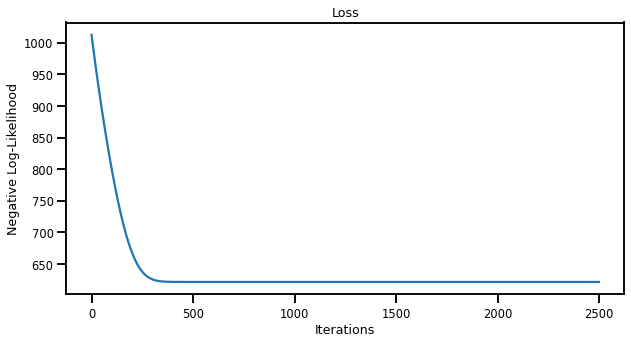

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.gcf()
wandb.log({"loss": wandb.Image(plt)})

#### Extract Params

In [17]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
# pprint(learned_params)

if inference != "mll":
    if model == "sparse":
        x_u = learned_params["x_u"]
        learned_params = guide.median(learned_params)
        learned_params["x_u"] = x_u
    elif model == "exact":
        learned_params = guide.median(learned_params)
    else:
        raise ValueError(f"Unrecognized model: {model}")


# pprint(learned_params)

## Predictions

In [18]:
if model == "sparse":
    from src.sparse import init_sgp_predictive

    gp_pred = init_sgp_predictive(
        RBF, learned_params, Xtrain_scaled, ytrain_scaled, jitter=1e-5
    )
elif model == "exact":
    from src.exact import init_gp_predictive

    gp_pred = init_gp_predictive(
        RBF, learned_params, Xtrain_scaled, ytrain_scaled, jitter=0.0
    )
else:
    raise ValueError(f"Unrecognized model: {model}")


mu_train = gp_pred.predict_mean(jnp.array(Xtrain_scaled))
mu_test = gp_pred.predict_mean(jnp.array(Xtest_scaled))

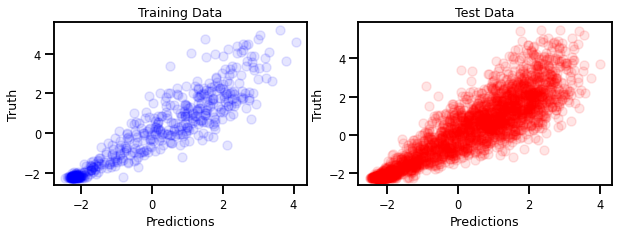

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].scatter(mu_train, ytrain_scaled, alpha=0.1, c="blue")
ax[0].set(xlabel="Predictions", ylabel="Truth", title="Training Data")

ax[1].scatter(mu_test, ytest_scaled, alpha=0.1, c="red")
ax[1].set(xlabel="Predictions", ylabel="Truth", title="Test Data")
plt.gcf()
wandb.log({"gp_pred_sim": wandb.Image(plt)})

### Statistics

In [20]:
from uncertainty_toolbox import get_all_metrics

In [21]:
mu, var = gp_pred.predict_y(Xtest_scaled)

std = jnp.sqrt(var.squeeze())

In [22]:
import numpy as np
import pandas as pd

metrics = get_all_metrics(
    y_pred=np.array(mu).ravel(),
    y_std=np.array(std).ravel(),
    y_true=np.array(ytest_scaled).ravel(),
)

wandb.log(metrics)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 10%|█         | 1/10 [00:00<00:01,  8.42it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 10%|█         | 1/10 [00:00<00:01,  8.02it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.536
  RMSE          0.769
  MDAE          0.349
  MARPD         55.411
  R2            0.827
  Correlation   0.909
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.105
  Mean-absolute Calibration Error       0.088
  Miscalibration Area                   0.088
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.111
     Group Size: 0.56 -- Calibration Error: 0.097
     Group Size: 1.00 -- Calibration Error: 0.088
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.131
     Group Size: 0.56 -- Calibration Error: 0.114
     Group Size: 1.00 -- Calibration Error: 0.105
===============

#### Plots

In [23]:
from uncertainty_toolbox import viz as utviz


def plot_all_uncertainty(y_pred, y_std, y_true, data):

    utviz.plot_parity(y_pred=mu.ravel(), y_true=y_true.ravel())
    plt.gcf()
    wandb.log({f"parity_{data}": wandb.Image(plt)})

    utviz.plot_calibration(y_pred=mu.ravel(), y_std=std.ravel(), y_true=y_true.ravel())
    plt.gcf()
    wandb.log({f"calib_{data}": wandb.Image(plt)})

    utviz.plot_intervals_ordered(
        y_pred=mu.ravel(), y_std=std.ravel(), y_true=y_true.ravel(), n_subset=100
    )
    plt.gcf()
    wandb.log({f"intervals_{data}": wandb.Image(plt)})

    utviz.plot_sharpness(y_std=std.ravel(),)
    plt.gcf()
    wandb.log({f"sharpness_{data}": wandb.Image(plt)})

    utviz.plot_adversarial_group_calibration(
        y_pred=mu.ravel(), y_std=std.ravel(), y_true=y_true.ravel(), n_subset=100
    )
    plt.gcf()
    wandb.log({f"adverse_{data}": wandb.Image(plt)})

### 

Lims is None. Setting lims now:
min_max_true: (-2.25253434829924, 5.51179509509576)
min_max_pred: (DeviceArray(-2.4984848, dtype=float32), DeviceArray(4.0027204, dtype=float32))
lims: (-2.4984848499298096, 5.51179509509576)
lims_ext: (-3.2995128444323667, 6.312823089598317)


/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


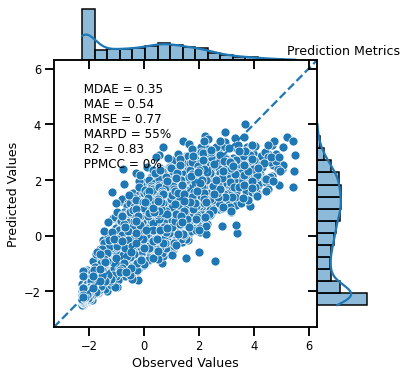

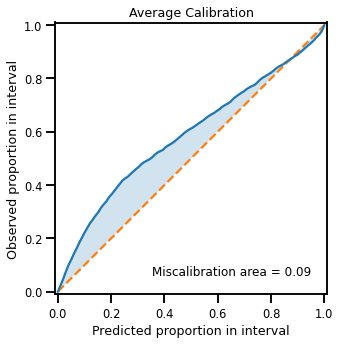

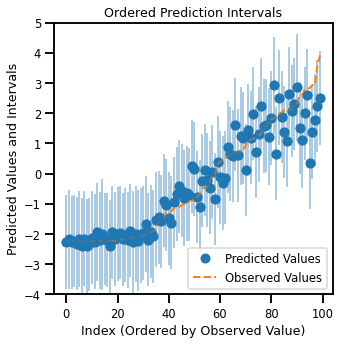

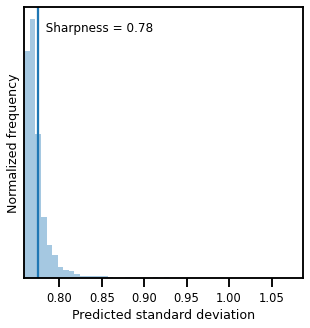

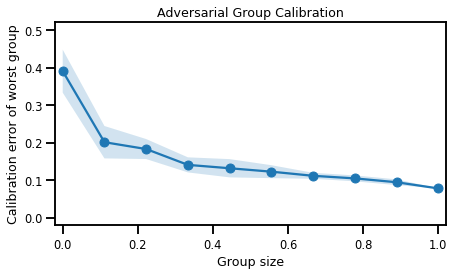

In [24]:
plot_all_uncertainty(mu, std, ytest_scaled, "sim")

## Test Data

In [25]:
ds_real = uncertain.load_histarfm_testing_df()

# drop nans
ds_real = ds_real.dropna()

# parse
Xreal_mu, Xreal_std, Y_real = uncertain.parse_histarfm_ds(ds_real)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


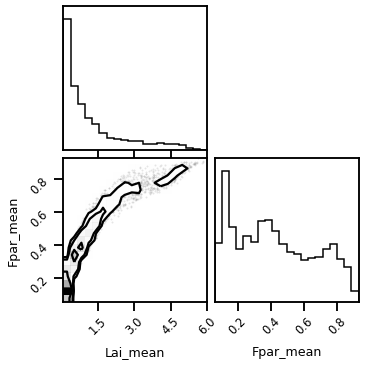

In [26]:
figure = corner.corner(Y_real)

In [27]:
Y_real.describe()

,Lai_mean,Fpar_mean
count,3320.000000,3320.000000
mean,1.287666,0.424059
std,1.320577,0.236908
min,0.100000,0.060000
25%,0.299295,0.210505
50%,0.754397,0.392066
75%,1.761429,0.620908
max,6.007066,0.929591


In [28]:
(Y_real * (0.5 / 255)).describe()

,Lai_mean,Fpar_mean
count,3320.000000,3320.000000
mean,0.002525,0.000831
std,0.002589,0.000465
min,0.000196,0.000118
25%,0.000587,0.000413
50%,0.001479,0.000769
75%,0.003454,0.001217
max,0.011779,0.001823


In [29]:
mu_scale = 1e-4
std_scale = 0.5 / 255

# apply ad-hoc transform
Xreal_mu *= mu_scale
Xreal_std *= std_scale

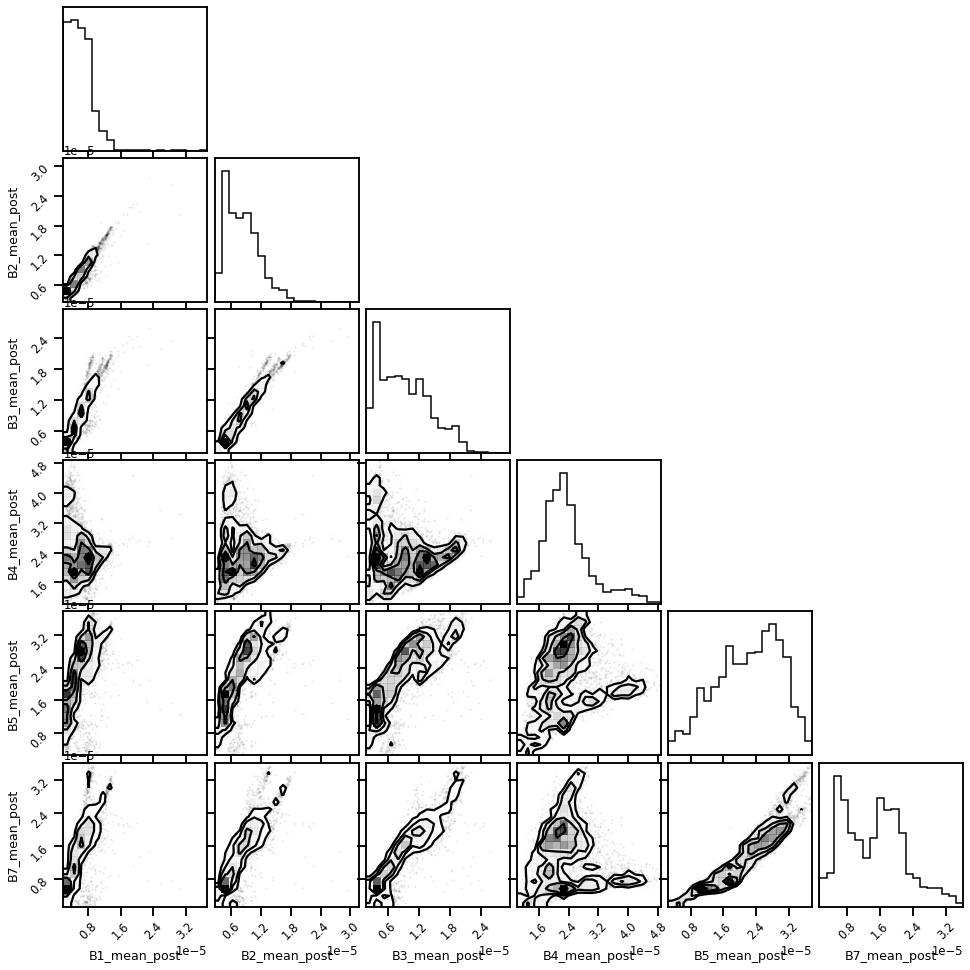

In [30]:
# Xtrain_scaled
figure = corner.corner(Xreal_mu * mu_scale, hist_factor=2)
plt.gcf()
wandb.log({"real_data_X": wandb.Image(plt)})

### Transforms

In [31]:
Xreal_mu_scaled = x_transformer.transform(Xreal_mu)
Xreal_std_scaled = x_transformer.transform(Xreal_std)

Y_real_scaled = y_transformer.transform(Y_real["Lai_mean"].values.reshape(-1, 1))

In [32]:
Y_real_scaled.min(), Y_real_scaled.max()

(-2.1525496049042396, 3.754516055624058)

In [33]:
mu_real = gp_pred.predict_mean(jnp.array(Xreal_mu_scaled))

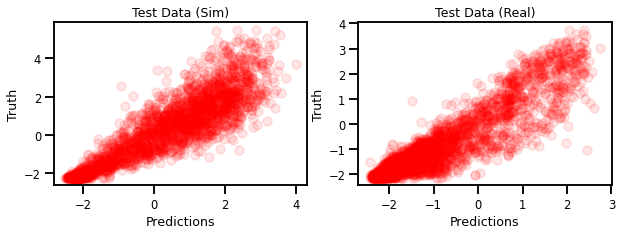

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].scatter(mu_test, ytest_scaled, alpha=0.1, c="red")
ax[0].set(xlabel="Predictions", ylabel="Truth", title="Test Data (Sim)")

ax[1].scatter(mu_real, Y_real_scaled, alpha=0.1, c="red")
ax[1].set(xlabel="Predictions", ylabel="Truth", title="Test Data (Real)")
plt.gcf()
wandb.log({"gp_pred_real": wandb.Image(plt)})

In [35]:
mu, var = gp_pred.predict_y(jnp.array(Xreal_mu_scaled))

std = jnp.sqrt(var.squeeze())

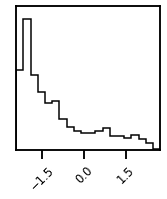

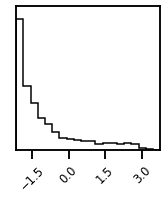

In [36]:
figure = corner.corner(mu)
figure = corner.corner(Y_real_scaled)

#### Statistics

In [37]:
import numpy as np
import pandas as pd

metrics = get_all_metrics(
    y_pred=np.array(mu).ravel(),
    y_std=np.array(std).ravel(),
    y_true=np.array(Y_real_scaled).ravel(),
)

wandb.log(metrics)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 10%|█         | 1/10 [00:00<00:01,  8.50it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 10%|█         | 1/10 [00:00<00:01,  8.08it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.372
  RMSE          0.527
  MDAE          0.249
  MARPD         39.305
  R2            0.841
  Correlation   0.918
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.196
  Mean-absolute Calibration Error       0.173
  Miscalibration Area                   0.175
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.192
     Group Size: 0.56 -- Calibration Error: 0.179
     Group Size: 1.00 -- Calibration Error: 0.173
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.219
     Group Size: 0.56 -- Calibration Error: 0.204
     Group Size: 1.00 -- Calibration Error: 0.196
===============

#### Plots

Lims is None. Setting lims now:
min_max_true: (-2.1525496049042396, 3.754516055624058)
min_max_pred: (DeviceArray(-2.4435794, dtype=float32), DeviceArray(2.745416, dtype=float32))
lims: (-2.4435794353485107, 3.754516055624058)
lims_ext: (-3.063388984445768, 4.374325604721315)


/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


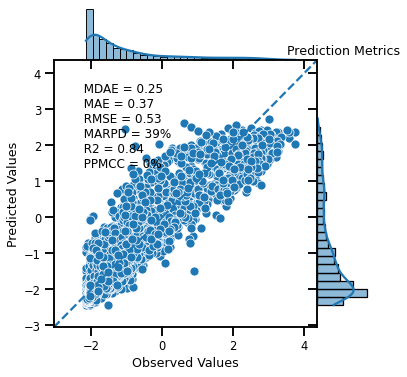

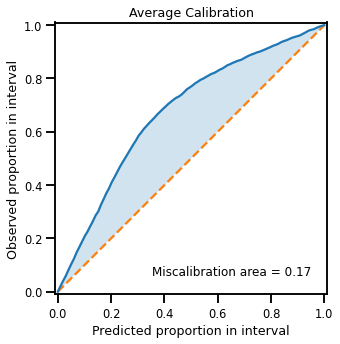

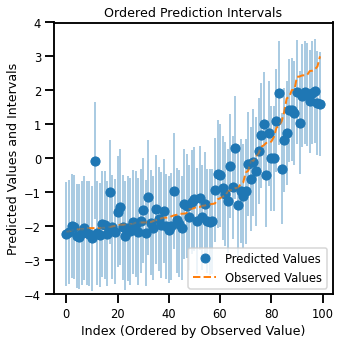

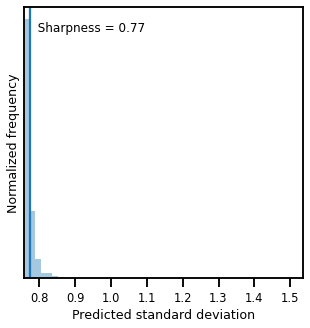

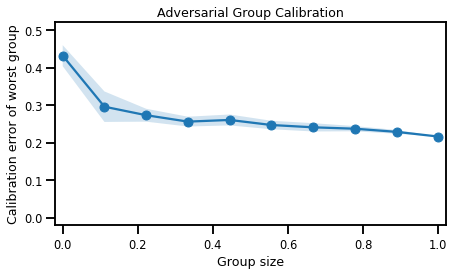

In [38]:
plot_all_uncertainty(mu, std, Y_real_scaled, "real")